In [1]:
import math
import collections

import pandas as pd

from keras.models import Model, Sequential
from keras.layers import *

import params
from utils.sequence_data import generator_for_binary_classifier, generator_to_samples_and_targets
from utils.metrics import print_report_for_binary_classfier
from utils.preprocessing import probs_to_binary_classes
from utils.plot import plot_train_validation_metric


Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("../datasets/train_test_data.csv",
                           header=0, parse_dates=[0], index_col=0)

#params for generator
label_index = len(dataset.columns) -1

In [12]:
train_max_idx = math.ceil(len(dataset)*params.TRAIN_RATIO)
val_max_idx = math.ceil(len(dataset)*(params.TRAIN_RATIO+params.VAL_RATIO))

# 1 step = 1 batche of samples 
train_steps = (train_max_idx+1 -params.LOOKBACK) // params.BATCH_SIZE
val_steps =  (val_max_idx - train_max_idx - params.LOOKBACK) // params.BATCH_SIZE
test_steps = (len(dataset) - val_max_idx - params.LOOKBACK) // params.BATCH_SIZE

In [13]:
#init generator_for_binary_classifiers
train_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=0,
                      max_index=train_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)



val_gen = generator_for_binary_classifier(dataset.to_numpy(),
                    label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=train_max_idx+1,
                      max_index=val_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)

test_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=val_max_idx+1,
                      max_index=None,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)


In [14]:
#build s FC model from the book

input_shape = (params.LOOKBACK//params.STEP, dataset.shape[-1] )

model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

# #fit the model
history = model.fit_generator(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                11552     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 12,641
Trainable params: 12,641
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
61/61 [==============================] - 1s 10ms/step - loss: 0.5895 - acc: 0.7244 - val_loss: 0.3231 - val_acc: 0.9868
Epoch 2/20
61/61 [==============================] - 0s 6ms/step - loss: 0.5809 - acc: 0.7480 - val_loss: 0.2914 - val_acc: 0.9868
Epoc

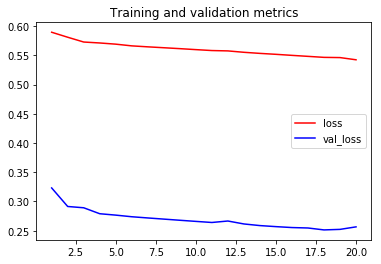

In [15]:
plot_train_validation_metric(history, 'loss', 'val_loss')

In [16]:
neg = 2762+158
pos = 177+807
print("We have {0} neg cases and {1} pos cases from train data".format(neg,pos))
print("the common sense baseline (accuracy score) is {0}".format(neg/(pos+neg)))

We have 2920 neg cases and 984 pos cases from train data
the common sense baseline (accuracy score) is 0.7479508196721312


In [17]:
#Make predictions for train set
    
X, Y = generator_to_samples_and_targets(train_gen, train_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 2920, 1.0: 984})
F1 score: 0.000000
precision score: 0.000000
recall score: 0.000000
accuracy score: 0.747951
matthews_corrcoef: 0.000000

Confusion matrix:
[[2920    0]
 [ 984    0]]


/home/kevin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kevin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kevin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [18]:
#Make predictions from dev set
X, Y = generator_to_samples_and_targets(val_gen, val_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 821, 1.0: 11})
F1 score: 0.000000
precision score: 0.000000
recall score: 0.000000
accuracy score: 0.986779
matthews_corrcoef: 0.000000

Confusion matrix:
[[821   0]
 [ 11   0]]


In [11]:
#Make predictions for test set
X, Y = generator_to_samples_and_targets(test_gen, test_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 802, 1.0: 30})
F1 score: 0.000000
precision score: 0.000000
recall score: 0.000000
accuracy score: 0.962740
matthews_corrcoef: -0.006709

Confusion matrix:
[[801   1]
 [ 30   0]]
